In [2]:
from pyexpat import features


p = catalog.load('parameters')
features = p["features"]
targets=p["targets"]
targets

[03/05/24 10:25:45] INFO     Loading data from 'parameters' (MemoryDataSet)...                  ]8;id=937733;file:///home/jack/miniconda3/envs/sampler/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=67619;file:///home/jack/miniconda3/envs/sampler/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

['Pg_f', 'Tg_Tmax']

In [3]:
data = catalog.load("treated_data")
data

[03/05/24 10:25:46] INFO     Loading data from 'treated_data' (CSVDataSet)...                   ]8;id=600618;file:///home/jack/miniconda3/envs/sampler/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=101359;file:///home/jack/miniconda3/envs/sampler/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

,r_ext_pAl,r_ext_pMeO,pAl_richness,Pg_f,Tg_Tmax,sim_time
0,0.998455,0.752775,0.832825,0.439480,0.861510,0.197198
1,0.884572,0.995134,0.489310,0.590641,0.910139,0.199398
2,0.773458,0.891320,0.651214,0.499086,0.883874,0.180005
3,0.513232,0.514477,0.939324,0.321652,0.782492,0.300134
4,0.304354,0.935717,0.096649,0.685096,0.909678,0.474074
...,...,...,...,...,...,...
95,0.718351,0.943936,0.267603,0.691238,0.936290,0.329701
96,0.898815,0.902096,0.025648,0.842482,0.954363,0.395611
97,0.907523,0.792940,0.956319,0.385089,0.845931,0.213779
98,0.059100,0.816113,0.633662,0.179282,0.562192,10.497417


In [4]:
import numpy as np
from scipy.spatial import Voronoi, voronoi_plot_2d
from scipy.spatial import ConvexHull

#initial_points = np.random.rand(4, 2)
# initial_points = np.array([[0.2, 0.2], [0.3, 0.3], [0.25, 0.3], [0.3, 0.25],
#                            [0.8, 0.8], [0.7, 0.7], [0.75, 0.8], [0.8, 0.75]])
initial_points = data[targets].values
points = data[features].values
# Compute the Voronoi diagram
global_vor = Voronoi(initial_points,
              incremental=True)

In [9]:
import matplotlib.pyplot as plt

def compute_voronoi_stats(n=None, points=None, use_global_vor=False, show_stats=False):
    if points is None:
        points = np.random.rand(n, 2)

    if use_global_vor:
        global_vor.add_points(points)
        vor = global_vor
    else:
        points = np.concatenate((global_vor.points, points))
        vor = Voronoi(points)

    def within_range(point):
        return (0 <= point[0] <= 1) and (0 <= point[1] <= 1)

    # Calculate the total area of complete cells and the number of completed cells
    total_area = 0
    num_complete_cells = 0
    for region_index in vor.point_region:
        region = vor.regions[region_index]
        if not -1 in region:
            # Get the vertices of the region
            vertices = vor.vertices[region]
            
            # Check if all vertices are within the [0, 1] region
            if all(within_range(vertex) for vertex in vertices):
                # Use convhull to calculate the area of the cell
                area = ConvexHull(vertices).volume
                                
                # Increment total area and complete cell count
                total_area += area
                num_complete_cells += 1
    if show_stats:
        print("-"*70)
        print("Total area of complete cells:", total_area)
        print("Number of complete cells:", num_complete_cells)

        if num_complete_cells > 0:
            print("Ratio:", round(total_area / num_complete_cells, 6))

        # Optionally, you can visualize the Voronoi diagram
        voronoi_plot_2d(vor, show_vertices=False)
        plt.show()

    return total_area, len(vor.points)


In [10]:
import numpy as np
from scipy.optimize import shgo
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

from tqdm import tqdm

# Define the function to compute z values
def compute_z_values(x, y):
    # Example function: z = sin(2*pi*x) * cos(2*pi*y)
    return np.sin(x*4*np.pi) + np.cos(y*4*np.pi)

# Define the target function (provided by the user)
def target_function(x):
    area, num_points = compute_voronoi_stats(n=None, points=x.reshape(1, -1))  
    return - area # Negative to find maximum

In [11]:


# Initialize Gaussian Process Regressor
kernel = 1.0 * RBF(length_scale=1.0)
gp_regressor = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

# Initial training data points (randomly sampled)
n_initial = 10
X_train = np.random.rand(n_initial, 2)
y_train = compute_z_values(X_train[:, 0], X_train[:, 1])

# Number of iterations for sampling new points
n_iterations = 1

# Iteratively sample new points and update the model
for i in tqdm(range(n_iterations)):
    # Find the global minimum of the target function using SHGO
    bounds = [(0.01, 0.99), (0.01, 0.99)]  # Bounds for x and y
    res = shgo(target_function, bounds, n=100, iters=5, sampling_method='simplicial')
    x_new, y_new = res.x
    
    print("New point sampled:", (x_new, y_new))
    area = compute_voronoi_stats(n=None, points=np.array([[x_new, y_new]]), use_global_vor=True, show_stats=True)
    print("Area:", area)
    # Compute the corresponding z value for the new point
    z_new = compute_z_values(x_new, y_new)
    
    # Add the new point to the training data
    X_train = np.vstack((X_train, [x_new, y_new]))
    y_train = np.append(y_train, z_new)
    
    # Update the Gaussian Process Regressor with the new data
    gp_regressor.fit(X_train, y_train)


  0%|          | 0/1 [00:13<?, ?it/s]


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:17                                                                                   │
│                                                                                                  │
│   14 for i in tqdm(range(n_iterations)):                                                         │
│   15 │   # Find the global minimum of the target function using SHGO                             │
│   16 │   bounds = [(0.01, 0.99), (0.01, 0.99)]  # Bounds for x and y                             │
│ ❱ 17 │   res = shgo(target_function, bounds, n=100, iters=5, sampling_method='simplicial')       │
│   18 │   x_new, y_new = res.x                                                                    │
│   19 │                                                                                           │
│   20 │   print("New point sampled:", (x_new, y_new))                                             │
│                                                                                                  │
│ /home/jack/miniconda3/envs/sampler/lib/python3.10/site-packages/scipy/optimize/_shgo.py:454 in   │
│ shgo                                                                                             │
│                                                                                                  │
│    451 │   │   │      options=options, sampling_method=sampling_method,                          │
│    452 │   │   │      workers=workers) as shc:                                                   │
│    453 │   │   # Run the algorithm, process results and test success                             │
│ ❱  454 │   │   shc.iterate_all()                                                                 │
│    455 │                                                                                         │
│    456 │   if not shc.break_routine:                                                             │
│    457 │   │   if shc.disp:                                                                      │
│                                                                                                  │
│ /home/jack/miniconda3/envs/sampler/lib/python3.10/site-packages/scipy/optimize/_shgo.py:833 in   │
│ iterate_all                                                                                      │
│                                                                                                  │
│    830 │   │   │   if self.break_routine:                                                        │
│    831 │   │   │   │   break                                                                     │
│    832 │   │   │   # Iterate complex, process minimisers                                         │
│ ❱  833 │   │   │   self.iterate()                                                                │
│    834 │   │   │   self.stopping_criteria()                                                      │
│    835 │   │                                                                                     │
│    836 │   │   # Build minimiser pool                                                            │
│                                                                                                  │
│ /home/jack/miniconda3/envs/sampler/lib/python3.10/site-packages/scipy/optimize/_shgo.py:1011 in  │
│ iterate                                                                                          │
│                                                                                                  │
│   1008 │   │   # Build minimizer pool                                                            │
│   1009 │   │   if self.minimize_every_iter:                                                      │
│   1010 │   │   │   if not self.break_routine:                                                    │
│ ❱ 1011 │   │   │   │   self.find_minima()  # Process minimi

In [ ]:
global_vor.points


array([[0.43948016, 0.86150986],
       [0.59064136, 0.91013918],
       [0.49908637, 0.88387411],
       [0.32165194, 0.78249237],
       [0.68509576, 0.9096776 ],
       [0.63520409, 0.87324915],
       [0.55299254, 0.8997577 ],
       [0.44998958, 0.85320519],
       [0.4719602 , 0.87586487],
       [0.65120426, 0.92605585],
       [0.7624074 , 0.95335326],
       [0.78785829, 0.95167711],
       [0.53856826, 0.85971822],
       [0.25806004, 0.72583164],
       [0.39005211, 0.81451993],
       [0.69651422, 0.94376929],
       [0.74453189, 0.94495049],
       [0.58708697, 0.90954897],
       [0.83646652, 0.953125  ],
       [0.60094392, 0.91296397],
       [0.41381897, 0.85728052],
       [0.48983848, 0.8812251 ],
       [0.40045094, 0.83813327],
       [0.77665816, 0.94788237],
       [0.4659686 , 0.87508249],
       [0.72870167, 0.94239587],
       [0.44637672, 0.86814707],
       [0.75718826, 0.95040554],
       [0.7925041 , 0.95828054],
       [0.42000517, 0.83279432],
       [0

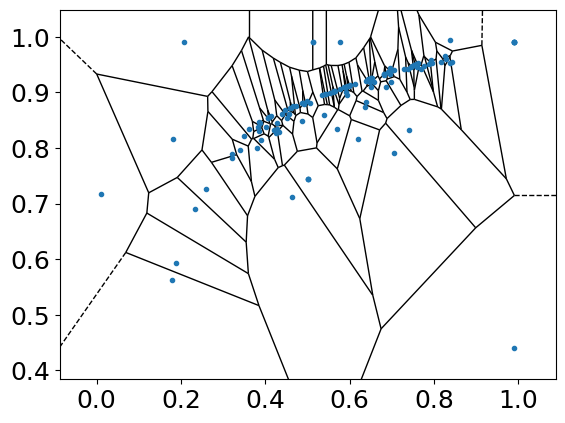

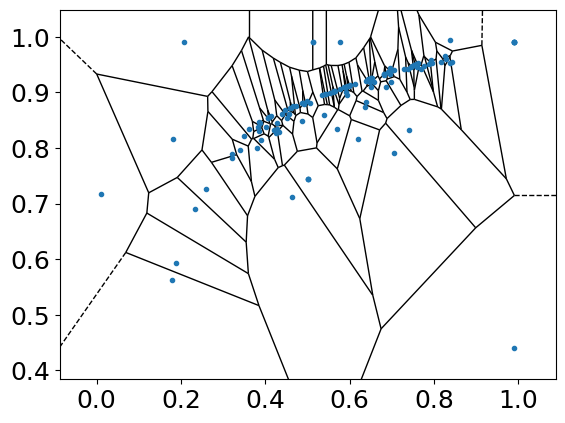

In [ ]:
voronoi_plot_2d(global_vor, show_vertices=False)

In [12]:
# Make 3d surface with plotly using a grid of x, y values and target_function to compute z
import plotly.graph_objects as go
import numpy as np

n = 100

x = np.linspace(0, 1, n)
y = np.linspace(0, 1, n)
X, Y = np.meshgrid(x, y)

Z = np.zeros((n, n))

for i in range(n):
    for j in range(n):
        Z[i][j] = target_function(np.array([X[i][j], Y[i][j]]))

fig = go.Figure(data=[go.Surface(z=Z, x=X, y=Y)])

# Add initial_data points to the plot
fig.add_trace(go.Scatter3d(x=initial_points[:, 0], y=initial_points[:, 1], z=[Z.max()]*len(initial_points),
                           mode='markers', marker=dict(size=5, color='red', opacity=0.8)))

fig.update_layout(legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01))
fig.update_layout(height=1000, margin=dict(l=0, r=0, b=0, t=0))
fig.show()

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in scipy._lib.messagestream.MessageStream.close:91                                               │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
TypeError: remove: path should be string, bytes or os.PathLike, not NoneType

Exception ignored in: 'scipy._lib.messagestream.MessageStream.__dealloc__'
Traceback (most recent call last):
  File "messagestream.pyx", line 91, in scipy._lib.messagestream.MessageStream.close
TypeError: remove: path should be string, bytes or os.PathLike, not NoneType


: 

In [ ]:
Z.min()

-0.2698080785277179

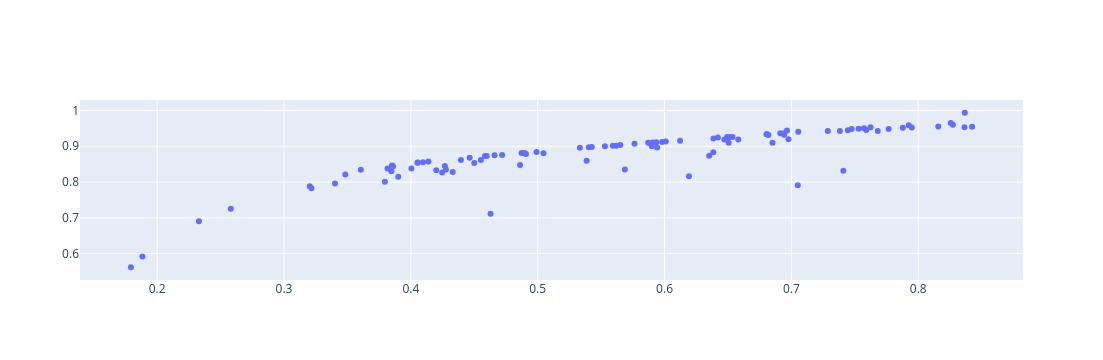

In [ ]:
# Plot scatter of initial_points
fig = go.Figure(data=[go.Scatter(x=initial_points[:, 0], y=initial_points[:, 1], mode='markers')])
fig.show()

In [7]:
def voronoi_plot_3d(vor, ax=None):
    """
    Plot the 3D Voronoi diagram.

    Parameters:
        vor (scipy.spatial.Voronoi): The Voronoi diagram to plot.
        ax (matplotlib.axes.Axes, optional): The axes to plot on. If not provided, a new figure and axes will be created.

    Returns:
        matplotlib.axes.Axes: The axes containing the plot.
    """
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

    # Plot the vertices
    ax.plot(vor.vertices[:, 0], vor.vertices[:, 1], vor.vertices[:, 2], 'ko')

    # Plot the ridge lines
    for simplex in vor.ridge_vertices:
        simplex = np.asarray(simplex)
        if np.all(simplex >= 0):
            ax.plot(vor.vertices[simplex, 0], vor.vertices[simplex, 1], vor.vertices[simplex, 2], 'k-')

    # Plot the points
    ax.plot(vor.points[:, 0], vor.points[:, 1], vor.points[:, 2], 'ro')

    # Plot the regions
    for region_index in vor.point_region:
        region = vor.regions[region_index]
        if -1 not in region:
            polygon = [vor.vertices[i] for i in region]
            ax.plot(np.append(polygon[:, 0], polygon[0, 0]), 
                    np.append(polygon[:, 1], polygon[0, 1]),
                    np.append(polygon[:, 2], polygon[0, 2]), 
                    'b-', alpha=0.5)

    return ax


In [8]:
import numpy as np
from scipy.spatial import Voronoi, ConvexHull
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # for 3D visualization

def compute_voronoi_stats_3d(n=None, points=None, use_global_vor=False, show_stats=False):
    if points is None:
        points = np.random.rand(n, 3)

    if use_global_vor:
        global_vor.add_points(points)
        vor = global_vor
    else:
        points = np.concatenate((global_vor.points, points))
        vor = Voronoi(points)

    def within_range(point):
        return all(0 <= p <= 1 for p in point)

    # Calculate the total volume of complete cells and the number of completed cells
    total_volume = 0
    num_complete_cells = 0
    for region_index in vor.point_region:
        region = vor.regions[region_index]
        if not -1 in region:
            # Get the vertices of the region
            vertices = vor.vertices[region]

            # Check if all vertices are within the [0, 1] region
            if all(within_range(vertex) for vertex in vertices):
                # Use convhull to calculate the volume of the cell
                volume = ConvexHull(vertices).volume

                # Increment total volume and complete cell count
                total_volume += volume
                num_complete_cells += 1

    if show_stats:
        print("-" * 70)
        print("Total volume of complete cells:", total_volume)
        print("Number of complete cells:", num_complete_cells)

        if num_complete_cells > 0:
            print("Average volume per complete cell:", round(total_volume / num_complete_cells, 6))

        # Optionally, you can visualize the Voronoi diagram
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        voronoi_plot_3d(vor, ax=ax)
        plt.show()

    return total_volume, len(vor.points)



array([[0.99845504, 0.75277465, 0.83282474],
       [0.88457235, 0.99513385, 0.48930961],
       [0.77345791, 0.89131969, 0.65121403],
       [0.51323181, 0.51447743, 0.93932437],
       [0.30435447, 0.9357173 , 0.09664853],
       [0.99573482, 0.50085757, 0.41341902],
       [0.9594833 , 0.95247008, 0.5766306 ],
       [0.59253498, 0.97090341, 0.68175715],
       [0.90618072, 0.71365579, 0.74237864],
       [0.92136753, 0.75623752, 0.37614675],
       [0.75856686, 0.60558678, 0.14775075],
       [0.92571474, 0.91676091, 0.12420375],
       [0.93674197, 0.44804603, 0.6023574 ],
       [0.36605523, 0.41307255, 0.97411534],
       [0.41712885, 0.76426881, 0.669587  ],
       [0.88690143, 0.56295113, 0.28477358],
       [0.82475298, 0.86806016, 0.19023498],
       [0.79111487, 0.98690832, 0.47779914],
       [0.94577377, 0.95816942, 0.04036551],
       [0.74440831, 0.92151692, 0.44002384],
       [0.78350845, 0.96023956, 0.84771037],
       [0.79042965, 0.85815016, 0.67569364],
       [0

In [11]:
compute_voronoi_stats_3d(n=None, points=points, use_global_vor=False, show_stats=False)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 compute_voronoi_stats_3d(n=None, points=points, use_global_vor=False, show_stats=False)      │
│   2                                                                                              │
│                                                                                                  │
│ in compute_voronoi_stats_3d:14                                                                   │
│                                                                                                  │
│   11 │   │   global_vor.add_points(points)                                                       │
│   12 │   │   vor = global_vor                                                                    │
│   13 │   else:                                                                                   │
│ ❱ 14 │   │   points = np.concatenate((global_vor.points, points))                                │
│   15 │   │   vor = Voronoi(points)                                                               │
│   16 │                                                                                           │
│   17 │   def within_range(point):                                                                │
│ in concatenate:180                                                                               │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, 
the array at index 0 has size 2 and the array at index 1 has size 3

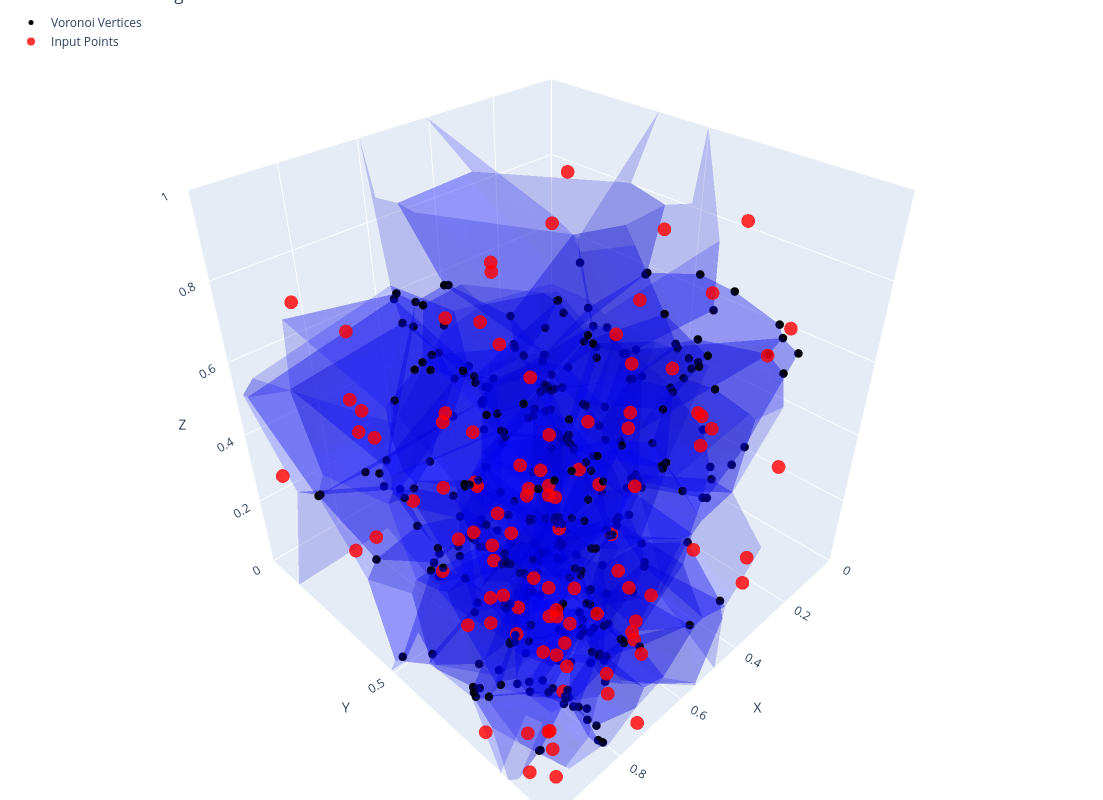

In [5]:
import numpy as np
from scipy.spatial import Voronoi
import plotly.graph_objects as go

def within_range(point):
    return all(0 <= p <= 1 for p in point)

# Generate random points in 3D space
#points = np.random.rand(10, 3)

# Create the Voronoi diagram
vor = Voronoi(points)

# Extract Voronoi vertices and ridge vertices
vertices = vor.vertices
ridge_vertices = vor.ridge_vertices
regions = vor.regions

# Plot the Voronoi diagram in 3D
fig = go.Figure()

# Plot the Voronoi vertices
fig.add_trace(go.Scatter3d(
    x=vertices[:, 0],
    y=vertices[:, 1],
    z=vertices[:, 2],
    mode='markers',
    marker=dict(
        size=5,
        color='black'
    ),
    name='Voronoi Vertices'
))

total_volume = 0
num_complete_cells = 0
# Plot the Voronoi regions
for region_index in range(len(regions)):
    region = regions[region_index]
    if -1 not in region and len(region) > 0:

        if all(within_range(vertex) for vertex in vertices):
            # Use convhull to calculate the volume of the cell
            volume = ConvexHull(vertices).volume

            # Increment total volume and complete cell count
            total_volume += volume
            num_complete_cells += 1


        x = [vertices[i][0] for i in region]
        y = [vertices[i][1] for i in region]
        z = [vertices[i][2] for i in region]
        fig.add_trace(go.Mesh3d(
            x=x,
            y=y,
            z=z,
            alphahull=0,
            opacity=0.2,
            color='blue',
            name='Voronoi Cell'
        ))

# Plot the input points
fig.add_trace(go.Scatter3d(
    x=points[:, 0],
    y=points[:, 1],
    z=points[:, 2],
    mode='markers',
    marker=dict(
        size=8,
        color='red',
        opacity=0.8
    ),
    name='Input Points'
))

# Update layout
fig.update_layout(
    scene=dict(
        xaxis=dict(title='X'),
        yaxis=dict(title='Y'),
        zaxis=dict(title='Z')
    ),
    title='3D Voronoi Diagram'
)
# Change axis only from 0 to 1
fig.update_layout(scene=dict(xaxis=dict(range=[0, 1]), yaxis=dict(range=[0, 1]), zaxis=dict(range=[0, 1])))
# Keep aspect ration 1 to 1 to 1
fig.update_layout(scene_aspectmode='cube')

fig.update_layout(legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01))
fig.update_layout(height=800, margin=dict(l=0, r=0, b=0, t=0))
fig.show()


In [29]:
print(total_volume)
print(num_complete_cells)

0
0
